In [23]:
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import LidarPointCloud
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl
import matplotlib as mpl

In [34]:
# # list all seaborn styles
# print(plt.style.available)

# # use seaborn style
# sns.set_theme(style="seaborn-deep")

plt.style.use('dark_background')

classes = {
    "animal" : 0,
    "human_pedestrian_adult" : 1,
    "human_pedestrian_child" : 2,
    "human_pedestrian_constructi" : 3,
    "human_pedestrian_personal_m" : 4,
    "human_pedestrian_police_off" : 5,
    "human_pedestrian_stroller" : 6,
    "human_pedestrian_wheelchair" : 7,
    "movable_object_barrier" : 8,
    "movable_object_debris" : 9,
    "movable_object_pushable_pul" : 10,
    "movable_object_trafficcone" : 11,
    "static_object_bicycle_rack" : 12,
    "vehicle_bicycle" : 13,
    "vehicle_bus_bendy" : 14,
    "vehicle_bus_rigid" : 15,
    "vehicle_car" : 16,
    "vehicle_construction" : 17,
    "vehicle_emergency_ambulance" : 18,
    "vehicle_emergency_police" : 19,
    "vehicle_motorcycle" : 20,
    "vehicle_trailer" : 21,
    "vehicle_truck" : 22
}

# get cmap from matplotlib
cm_viridis = mpl.cm.get_cmap('viridis')
cm_hsv = mpl.cm.get_cmap('hsv')
cm_gp2 = mpl.cm.get_cmap('gnuplot2')
cm_gistrb = mpl.cm.get_cmap('gist_rainbow')
cm_rb = mpl.cm.get_cmap('rainbow')

class_colors = {
    name : color
    for name, color in zip(classes.keys(), cm_rb(np.linspace(0, 1, len(classes))))
}
# class_colors_arr = np.array(list(class_colors.values()))

# print(cm_rb(np.linspace(0, 1, len(classes)))[0])

print(list(class_colors.values())[1])

[0.41372549 0.13510525 0.99770518 1.        ]


/tmp/ipykernel_3815102/1273522140.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_viridis = mpl.cm.get_cmap('viridis')
/tmp/ipykernel_3815102/1273522140.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_hsv = mpl.cm.get_cmap('hsv')
/tmp/ipykernel_3815102/1273522140.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm_gp2 = mpl.cm.get_cmap('gnuplot2')
/tmp/ipykernel_3815102/1273522140.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in 

In [3]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes, BoxVisibility

nusc = NuScenes(version='v1.0-trainval', dataroot='/home/cv08f23/datasets/nuScenes/v1.0-trainval', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 21.4 seconds.
Reverse indexing ...
Done reverse indexing in 5.5 seconds.


In [16]:
nusc.list_categories()

Category stats for split v1.0-trainval:
animal                      n=  787, width= 0.37±0.13, len= 0.86±0.36, height= 0.60±0.20, lw_aspect= 2.35±0.69
human.pedestrian.adult      n=208240, width= 0.67±0.13, len= 0.73±0.19, height= 1.77±0.18, lw_aspect= 1.11±0.26
human.pedestrian.child      n= 2066, width= 0.51±0.14, len= 0.53±0.15, height= 1.38±0.25, lw_aspect= 1.05±0.23
human.pedestrian.constructi n= 9161, width= 0.72±0.20, len= 0.71±0.20, height= 1.74±0.30, lw_aspect= 1.02±0.29
human.pedestrian.personal_m n=  395, width= 0.62±0.12, len= 1.18±0.31, height= 1.71±0.27, lw_aspect= 1.98±0.64
human.pedestrian.police_off n=  727, width= 0.73±0.14, len= 0.69±0.13, height= 1.83±0.14, lw_aspect= 0.97±0.18
human.pedestrian.stroller   n= 1072, width= 0.63±0.13, len= 0.95±0.27, height= 1.17±0.15, lw_aspect= 1.58±0.68
human.pedestrian.wheelchair n=  503, width= 0.77±0.10, len= 1.09±0.23, height= 1.37±0.09, lw_aspect= 1.42±0.23
movable_object.barrier      n=152087, width= 2.53±0.64, len= 0.50±0.17,

In [4]:
def points_from_sample(token: str, idx_frame: int = 0) -> np.ndarray:

    # Select a random sample
    # my_sample = nusc.sample[idx_frame]
    my_sample = nusc.get('sample', token)

    # Get the first LIDAR measurement in this sample
    lidar_token = my_sample['data']['LIDAR_TOP']

    # Get the LIDAR data
    lidar_data = nusc.get('sample_data', lidar_token)

    # Load the point cloud data
    pcl_path = nusc.get_sample_data_path(lidar_token)
    pointcloud = LidarPointCloud.from_file(pcl_path)

    # Transform the point cloud to the global frame
    cs_record = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', lidar_data['ego_pose_token'])

    # pointcloud.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    # pointcloud.translate(np.array(cs_record['translation']) + np.array(pose_record['translation']))

    # Convert the point cloud to a numpy array
    pointcloud_np = pointcloud.points

    return pointcloud_np.T

In [49]:

# plot 3D point cloud
def plot_point_cloud(figure, points):
    fig, ax = figure
    distance = np.sqrt(np.sum(points[:,:3] ** 2, axis=1))
    normalized_distance = (distance - np.min(distance)) / (np.max(distance) - np.min(distance))
    normalized_distance = np.sqrt(normalized_distance ** (2/3))
    sc = ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s=0.4, edgecolors="none", alpha=1, c=normalized_distance, cmap='jet')

def plot_detections(figure, dets, pred_labels, pred_scores):
    fig, ax = figure

    # det = dets[0]
    # label = pred_labels[0]

    for det, label, score in zip(dets, pred_labels, pred_scores):
        if score < 0.35:
            continue
        
        # find the corners of the box
        center_x, center_y, center_z, l, w, h, yaw, _, _ = det

        corners_x = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]]).T
        corners_y = np.array([[w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]]).T
        corners_z = np.array([[h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]]).T
        points = np.hstack((corners_x, corners_y, corners_z))

        # rotation matrix
        R = np.array([[np.cos(-yaw), -np.sin(-yaw), 0],
                    [np.sin(-yaw),  np.cos(-yaw), 0],
                    [           0,             0, 1]])
        # rotate the box
        points = points @ R

        # offset the box with center position
        points[:, 0] += center_x
        points[:, 1] += center_y
        points[:, 2] += center_z

        # colors
        line_c = list(class_colors.values())[label]
        line_a = 1
        line_w = 0.5

        # plot 12 lines of bounding box
        for i in range(4):
            ax.plot3D(points[[i, i+4], 0], points[[i, i+4], 1], points[[i, i+4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(points[[i, (i+1)%4], 0], points[[i, (i+1)%4], 1], points[[i, (i+1)%4], 2], c=line_c, alpha=line_a, linewidth=line_w)
        for i in range(4):
            ax.plot3D(points[[i+4, (i+1)%4+4], 0], points[[i+4, (i+1)%4+4], 1], points[[i+4, (i+1)%4+4], 2], c=line_c, alpha=line_a, linewidth=line_w)

    


def plot_all(points, dets, pred_labels, pred_scores, zoom=1, title=None, show_axis=True, show=True, save_to_file=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # zooming
    lim = (-100 / zoom, 100 / zoom) 
    
    if show_axis:
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_xlim3d(lim[0], lim[1])
        ax.set_ylim3d(lim[0], lim[1])
        ax.set_zlim3d(lim[0], lim[1])
        ax.set_axis_off()
    
    plot_point_cloud((fig, ax), points)
    plot_detections((fig, ax), dets, pred_labels, pred_scores)

    ax.set_aspect("equal", adjustable="box")
        
    if save_to_file:
        plt.savefig(f"img/vis/{title}.png", dpi=300)
    
    if show:
        plt.show()

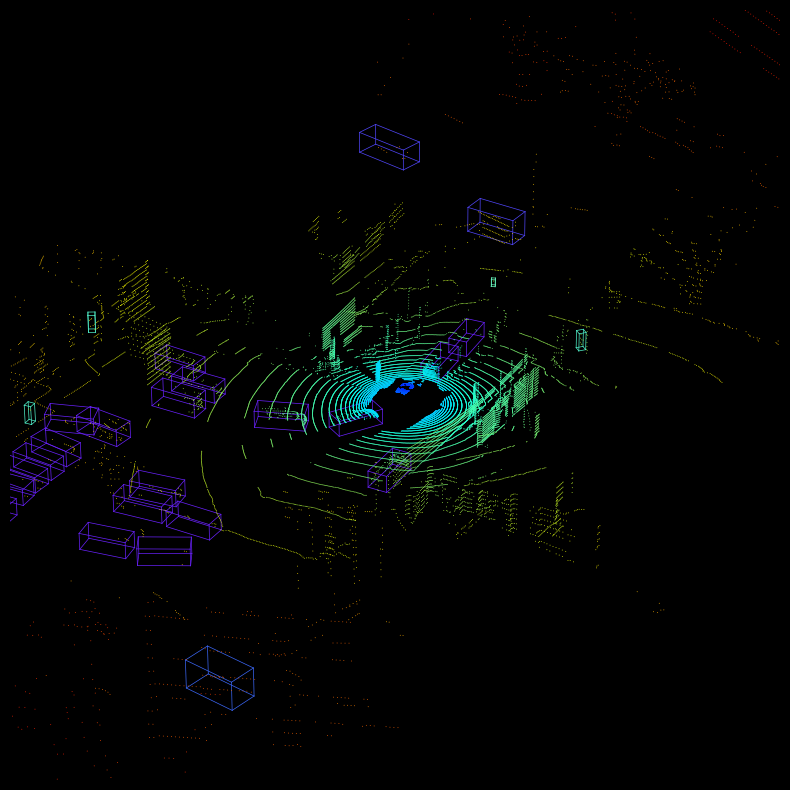

In [50]:
frame = cp_0_100[0]
token = frame['metadata']['token']
points = points_from_sample(token)
dets = frame['boxes_lidar']
pred_labels = frame['pred_labels']
pred_scores = frame['score']
plot_all(points, dets, pred_labels,pred_scores, zoom=5, show=True, save_to_file=False)

In [7]:
centerpoint_pkl_path = "/home/cv08f23/point-cloud-object-tracking/OpenPCDet/output/cfgs/nuscenes_models/cbgs_voxel01_res3d_centerpoint/default/eval/epoch_01/val/default/result.pkl"

cp_0_100 = pkl.load(open(centerpoint_pkl_path, "rb"))


cp_0_100[0]['metadata']

first_sample_token = cp_0_100[0]['metadata']['token']
last_sample_token = cp_0_100[-1]['metadata']['token']
print(first_sample_token)
print(last_sample_token)
my_sample = nusc.get('sample', first_sample_token)


my_sample['scene_token']

scene = nusc.get('scene', my_sample['scene_token'])
last_scene_sample_token = scene['last_sample_token']


for idx, sample in enumerate(cp_0_100):
    if sample['metadata']['token'] == last_scene_sample_token:
        print(idx)

fd8420396768425eabec9bdddf7e64b6
f0ee73d43c2748fbb584d1a062e2773a
39


In [41]:
cp_0_100 = pkl.load(open(centerpoint_pkl_path, "rb"))

print(cp_0_100[0].keys())

print(cp_0_100[0]['boxes_lidar'][0])
print(cp_0_100[0]['pred_labels'])
print(cp_0_100[0]['score'][0])

dict_keys(['name', 'score', 'boxes_lidar', 'pred_labels', 'frame_id', 'metadata'])
[ 5.13878250e+00 -1.17067375e+01 -1.42107034e+00  4.46498251e+00
  1.87670851e+00  1.65619957e+00 -1.54673028e+00  1.77349668e-09
 -8.51024584e-09]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  3  2  2  3  2  2  2  2  3
  2  2  3  2  2  2  3  3  3  3  2  4  4  5  5  4  5  4  4  5  5  4  4  5
  5  5  5  4  5  4  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  8  8  7
  8  8  8  7  7  8  8  8  7  7  8  8  8  8  8  7  7  8  8  8  7  8  8  8
  8  8  7  9  9  9 10  9 10  9 10 10  9 10 10  9 10  9 10  9 10  9  9  9
  9 10 10  9 10  9  9  9 10  9  9 10 10  9  9  9  9 10 10  9  9  9 10  9
 10 10  9  9 10  9  9  9  9  9  9 10 10 10  9  9  9  9 10  9  9 10 10 10
  9  9  9  9 10]
0.92468446


In [ ]:
prev_scene_token = None
idx_frame = 1
for frame in cp_0_100:
    if prev_scene_token != frame['metadata']['token']:
        idx_frame = 1
    
    token = frame['metadata']['token']
    sample = nusc.get('sample', token)

    points = points_from_sample(token)
    dets = frame['boxes_lidar']

    scene_token = sample['scene_token']
    title = f"{scene_token[0:5]}_{0 if idx_frame < 10 else None}{idx_frame}"

    plot_all(points, dets, zoom=5, title=title, show=False, save_to_file=True)
    idx_frame += 1